In [1]:
import numpy as np
import sklearn as sk
import sklearn.linear_model as sklm
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
# import pickle # save into bytes file

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
sys.path.append('../../Data_Preprocessing//')
from Metric import *
from Visualization import *
from Data_Extractor import *

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load & Construct training & test set:

In [3]:
# Load
path_train_set = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_topleft_coord_split_8_train"

train_set = h5py.File(path_train_set, 'r')
train_pos_topleft_coord = np.array(train_set['positive_example'])
train_neg_topleft_coord = np.array(train_set['negative_example'])
train_raw_image = np.array(train_set['raw_image'])
train_road_mask = np.array(train_set['road_mask'])
train_set.close()

print(train_raw_image.shape, train_road_mask.shape)

# Construct training & test set
pos_size = train_pos_topleft_coord.shape[0]
neg_size = train_neg_topleft_coord.shape[0]
print("pos=", pos_size, "neg=", neg_size)

(7, 6791, 8091) (6791, 8091)
pos= 320813 neg= 22784183


In [4]:
Train_Data = Data_Extractor (train_raw_image, train_road_mask, 8,
                             pos_topleft_coord = train_pos_topleft_coord,
                             neg_topleft_coord = train_neg_topleft_coord)

print("pos = ", Train_Data.pos_size, "neg = ", Train_Data.neg_size)

pos =  320813 neg =  22784183


In [5]:
for coord, patch in Train_Data.iterate_raw_image_patches_with_coord(norm=False):
    if not (patch != -9999).all():
        print(coord)
        break

[2128 1782]


Model parameters: 

In [5]:
width = 8
height = 8
band = 7

batch_size = 64
learning_rate = 9e-6
epoch = 15
iteration = int(Train_Data.size / batch_size) + 1

# emphasize on pos example
log_classifier = sklm.SGDClassifier(loss='log', max_iter=1, 
                                    class_weight={0:Train_Data.pos_size/Train_Data.size,
                                                  1:Train_Data.neg_size/Train_Data.size})
all_classes = np.array([0, 1])
print(log_classifier)

SGDClassifier(alpha=0.0001, average=False,
       class_weight={0: 0.013885005649860315, 1: 0.9861149943501397},
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [6]:
model_path = './Result/motor_trunk_pri_sec_tert_uncl_track/sklearn - central pixel/'
model_name = 'sklearn_split_weighted_pos0'

Train & monitor:

In [7]:
learning_curve = []
for epoch_num in range(epoch):
    for iter_num in range(iteration):

        batch_x, batch_y = Train_Data.get_patches(batch_size=batch_size, positive_num=8, norm=True)
        batch_x = batch_x.reshape((batch_size, -1))
        
        log_classifier.partial_fit(batch_x, batch_y, all_classes)

    # snap shot
    cost = log_classifier.decision_function(batch_x).mean()
    learning_curve.append(cost)
    print("acc = ", log_classifier.score(batch_x, batch_y), " cross entropy = ", cost)

print("finish")

acc =  0.546875  cross entropy =  15057.105685921813
acc =  0.859375  cross entropy =  -18411.283630322214
acc =  0.65625  cross entropy =  -4121.238686741095
acc =  0.796875  cross entropy =  -14386.182018022955
acc =  0.5625  cross entropy =  3985.4786032310017
acc =  0.5  cross entropy =  6825.063483530894
acc =  0.59375  cross entropy =  1901.409104682518
acc =  0.828125  cross entropy =  -5513.874889863262
acc =  0.390625  cross entropy =  6864.060340648249
acc =  0.671875  cross entropy =  -3759.2166392058502
acc =  0.671875  cross entropy =  -1839.8352297749943
acc =  0.53125  cross entropy =  778.9067260670723
acc =  0.75  cross entropy =  -2743.8922752455937
acc =  0.671875  cross entropy =  -1236.9851042778787
acc =  0.765625  cross entropy =  -5963.519030740603
finish


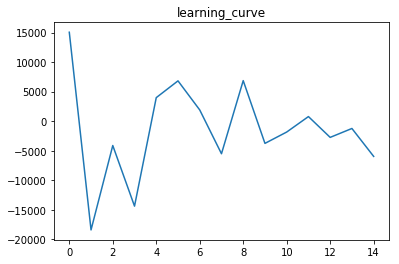

In [8]:
# plot training curve
plt.figsize=(9,5)
plt.plot(learning_curve)
plt.title('learning_curve')
plt.show()

(Optional) Save the model

In [10]:
from sklearn.externals import joblib
joblib.dump(log_classifier, model_path+model_name) 

saved_sk_obj = joblib.load(model_path+model_name)
assert (saved_sk_obj.coef_ == log_classifier.coef_).all()

Reload model

In [ ]:
# reload
from sklearn.externals import joblib
log_classifier = joblib.load(model_path+model_name)

Evaluate:

In [12]:
print(log_classifier.coef_.shape)
print(log_classifier.coef_.max(), log_classifier.coef_.min())
print(log_classifier.coef_)

(1, 448)
31.336387451013962 -21.46674658944571
[[ 1.36851460e+00  3.44255374e-01  1.10202111e+00  1.04734300e+00
  -7.95243154e-01 -8.07214412e-01 -3.14870016e-01 -3.27703528e-01
   2.13969338e+00  8.77943906e-02 -1.81159468e-01  2.08576190e+00
   5.73972349e-01  4.76273760e-01 -3.37695017e-01  4.99024102e-01
   2.13396702e+00 -3.62074887e-01  3.77282464e-01  4.15794073e-01
   8.47751171e-02  7.58768097e-01 -1.62701142e-01  6.27812295e-01
   2.87286647e+00  2.02818747e+00  7.63509869e-01 -3.80071453e+00
  -1.23325511e+01 -5.35053841e+00  8.27400256e-01  1.71704421e+00
   1.08984608e+00  7.55393599e-01  1.05967999e+00 -5.82535175e+00
  -2.14667466e+01 -8.68711702e+00  9.14206235e-01  1.24354090e+00
   1.47795235e+00 -2.08173073e-01  1.30614439e+00 -2.29472468e+00
  -1.01384499e+01 -3.96156958e+00  6.68000238e-01  2.38616374e+00
   1.77430126e+00  1.71102591e+00  5.33255623e-01  1.62288731e+00
   1.34457939e+00  2.29480440e+00  9.62456531e-01  1.81279293e+00
   4.77064399e-01  1.76581598

In [ ]:
train_metric = Metric()

for x, y in Train_Data.iterate_data(norm=True):
    x = x.reshape((1, -1))
    
    # record metric
    pred = log_classifier.predict(x)
    train_metric.accumulate(np.array([pred]), np.array([y]))
    
train_metric.print_info()

In [ ]:
test_metric = Metric()

for x, y in Test_Data.iterate_data(norm=True):
    x = x.reshape((1, -1))
    
    # record metric
    pred = log_classifier.predict(x)
    test_metric.accumulate(np.array([pred]), np.array([y]))
    
test_metric.print_info()

Load whole dataset

In [11]:
path_raw_image = "../../Data/090085/090085_20170531.h5"
path_road_mask = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/motor_trunk_pri_sec_tert_uncl_track.tif"

raw_image = np.array(h5py.File(path_raw_image)['scene'])
road_mask = skimage.io.imread(path_road_mask)

Predict road prob masks

In [ ]:
index = np.where(log_classifier.classes_ == 1)[0][0]
print(log_classifier.classes_, index)

pred_road = np.zeros(train_road_mask.shape)
for coord, patch in Train_Data.iterate_raw_image_patches_with_coord(norm=True):
    patch = patch.reshape([1,-1])
    
    pred_road[int(coord[0]+width/2), int(coord[1]+width/2)] = log_classifier.predict_proba(patch)[0, index]

[0 1] 1


/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [14]:
prediction_name = model_name + '_pred.h5'

h5f_file = h5py.File(model_path + prediction_name, 'w')
h5f_file.create_dataset (name='pred_road', data=pred_road)
h5f_file.close()

Load prediction

In [6]:
# restore prediction 
prediction_name = model_name + '_pred.h5'

h5f_file  = h5py.File(model_path + prediction_name, 'r')
pred_road = np.array(h5f_file['pred_road'])
h5f_file.close()

Analyze pred

In [ ]:
print(pred_road.min(), pred_road.max(), pred_road.mean())
plt.hist(x=pred_road.flatten(), bins=100, histtype='step')
plt.show()
plt.close()
plt.hist(x=pred_road[np.where(pred_road>0)].flatten(), bins=100, histtype='step')
plt.show()
plt.close()

In [ ]:
show_pred_prob_with_raw(train_raw_image, pred_road, train_road_mask, pred_weight=0.2, figsize=(50,50), 
                        show_plot=True)
#                         save_path=model_path + 'Analysis/prob_road_on_raw - 0_1.png')

Analyze log pred

In [8]:
log_pred = -np.log(-pred_road + 1 + 1e-7)
print(log_pred.min(), log_pred.max(), log_pred.mean())

norm_log_pred = (log_pred - log_pred.min()) / (log_pred.max()-log_pred.min())
print(norm_log_pred.min(), norm_log_pred.max(), norm_log_pred.mean())

-9.999999505838704e-08 16.11809565095832 0.5997394716039092
0.0 1.0 0.037209083558657895


In [ ]:
show_pred_prob_with_raw(raw_image, norm_log_pred,
                        true_road=road_mask, pred_weight=0.2, figsize=(150,150), show_plot=False,
                        save_path=model_path + 'Analysis/log_prob_on_raw - 0_2.png')

In [ ]:
plt.imshow(np.array([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]), cmap='hot')
plt.show()
plt.figure(figsize=(100,100))
plt.imshow(pred_road, cmap=plt.get_cmap('hot'))
plt.show()
plt.close()

In [ ]:
plt.imshow(np.array([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]), cmap='hot')
plt.show()
plt.figure(figsize=(100,100))
plt.imshow(np.log(pred_road + 1e-9), cmap='hot')
plt.show()
plt.close()